In [162]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings('always') 
warnings.filterwarnings('ignore')  # import warnings on every run: "error", "ignore", "always", "default", "module" or "once"

import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [163]:
pip install pandasql

Note: you may need to restart the kernel to use updated packages.


In [164]:
from pandasql import sqldf

In [165]:
pysqldf = lambda q: sqldf(q, globals())

We have multiple datasets. Let's explore them one by one and learn what information each csv file has.

# EXPLORING, CLEANING AND MERGING  DATASETS

We are going to explore what information each dataset has what errors each one might have in order to clean them and then we are going to merge all the needed information in one dataset.

In [166]:
courses = pd.read_csv(f'Resources/courses.csv')
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


This file contains the list of all available modules and their presentations. The columns are:

* code_module : code name of the module, which serves as the identifier.
* code_presentation : code name of the presentation. It consists of the year and “B” for the presentation starting in February and “J” for the presentation starting in October.
* module_presentation_length : length of the module-presentation in days.
<br> <br>
The structure of B and J presentations may differ and therefore it is good practice to analyse the B and J presentations separately. Nevertheless, for some presentations the corresponding previous B/J presentation do not exist and therefore the J presentation must be used to inform the B presentation or vice versa. In the dataset this is the case of CCC, EEE and GGG modules.

In [167]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 660.0+ bytes


In [168]:
list = ['code_module', 'code_presentation', 'module_presentation_length']
for i in list:
    print(courses[i].unique())

['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
['2013J' '2014J' '2013B' '2014B']
[268 269 262 240 234 241 261]


As, we can see above, there are 7 courses, the year that started are 2013 and 2014 in February or October and the days of the presentation are between 234 and 269. 

We can also observe that we have 22 rows that means that some courses started in 2014 not 2013, or else we would have 28 rows. Let's check it to see which of them started in 2013.

## Merge assessments and student_assessment

In the two datasets about assesment we have the weight of every assessment and the score that every student had in every assessment that took part. I believe it would be a good parameter for our prediction, to have the score that every student had in all the assessments of every module. Therefore, we will merge those to datasets to have our desired outcome.

### Explore the datasets

In [169]:
assessments = pd.read_csv(f'Resources/assessments.csv')
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


This file contains information about assessments in module-presentations. Usually, every presentation has a number of assessments (TMA, CMA) with different weights where they sum up to a total of 100%, followed by the final exam. CSV contains columns:

* code_module : identification code of the module, to which the assessment belongs.
* code_presentation : identification code of the presentation, to which the assessment belongs.
* id_assessment : identification number of the assessment.
* assessment_type : type of assessment. Three types of assessments exist: Tutor Marked Assessment (TMA), Computer Marked Assessment (CMA) and Final Exam (Exam).
* date : information about the final submission date of the assessment calculated as the number of days since the start of the module-presentation. The starting date of the presentation has number 0 (zero).
* weight : weight of the assessment in %. Typically, Exams are treated separately and have the weight 100%; the sum of all other assessments is 100%.
<br> <br>
If the information about the final exam date is missing, it is at the end of the last presentation week. But we are not going to use this column, so let's move on.

In [170]:
assessments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


id_assessment column is numerical. However, since it represents the identification number of assessment, any numerical operations should not be applied to it and therefore we are going to transform it into a string type.

In [171]:
# converitng column from int to str
assessments['id_assessment'] = assessments['id_assessment'].apply(lambda x: str(int(x)))

# counting how many unique assessments are in the dataset:
len(assessments['id_assessment'].unique())

206

In [172]:
# checking the unique values of the dataframe
list = ['code_module', 'code_presentation', 'assessment_type', 'date', 'weight']
for i in list:
    print(assessments[i].unique())

['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
['2013J' '2014J' '2013B' '2014B']
['TMA' 'Exam' 'CMA']
[ 19.  54. 117. 166. 215.  nan  89. 124. 159. 187.  47.  96. 131. 208.
  82. 152. 194.  12.  40. 110. 201.  18.  67. 137. 207.  32. 102. 151.
 200. 144. 214. 109. 158.  23.  51.  79. 114. 149. 170. 206.  25.  53.
  81. 116. 240.  88. 123. 165. 261.  74. 241.  20.  41.  62. 111. 146.
 195.  33.  68. 235. 228. 222. 236. 173. 227.  24.  52.  87. 129. 171.
  94. 136. 199. 229.  61.]
[ 10.   20.   30.  100.    1.    5.   18.    0.   35.    2.    7.    8.
   9.   22.    3.    4.    6.    7.5  12.5  15.   17.5  25.   16.   28. ]


In [173]:
student_assessment = pd.read_csv(f'Resources/studentAssessment.csv')
student_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


This file contains the results of students’ assessments. If the student does not submit the assessment, no result is recorded. The final exam submissions is missing, if the result of the assessments is not stored in the system. This file contains the following columns:

* id_assessment : the identification number of the assessment.
* id_student : a unique identification number for the student.
* date_submitted : the date of student submission, measured as the number of days since the start of the module presentation.
* is_banked : a status flag indicating that the assessment result has been transferred from a previous presentation.
* score : the student’s score in this assessment. The range is from 0 to 100. The score lower than 40 is interpreted as Fail. The marks are in the range from 0 to 100.

In [174]:
student_assessment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


In [175]:
# converitng column from int to str
student_assessment['id_assessment'] = student_assessment['id_assessment'].apply(lambda x: str(int(x)))
student_assessment['id_student'] = student_assessment['id_student'].apply(lambda x: str(int(x)))

In [176]:
# checking the unique values of the dataframe
list = ['date_submitted', 'is_banked', 'score'] 
for i in list:    
    print(student_assessment[i].unique())

[ 18  22  17  26  19  20   9  21  16  30  32  10  25  15  54  24  33  27
  23  37  29   7  58  12  14  50  36  56  53  51  52  64  61  70 106  57
  59  48  62  55  68  69  67  63  49  47  75  60  95  65  90  66 116  42
  72  92 114 146 117 115 112 120 124 121 111 110 122  85 139 123 130 113
 118 135 127  78 134 108 126 107 119 131 138 125 100 102  94 133 128 164
 165 181 166 173 161 170 157 171 163 177 183 172 168 180 158 159 179 153
 175 169 176 174 152 156 150 162 167 178 187 188 160 215 213 212 219 214
 216 217 218 209 211 220 203 221 223 208 238 207 222 227 198 202 239 210
 204 201 194  -1  13  39   5  28  31  38  40  11  45  84  74  35  71  46
  44  93 109 132 144 129 137  79 136 185 184 155 237 224 234 205 235 226
  -4   6  41  -5  77  -3  43  91  34   8   1   3   4  -6  97  80  88  86
  81  76 186  83  89 104  87  99 101  96  98 103  82 105 193 141 142 145
 140 147 148 143 154 151 149 189 191 197 182 192 195 199 190 206 200 196
   0   2  -2  -9 228  73 229 236 -11  -7 270 233 23

In [177]:
# merging the two dataframes
df_assessments = assessments.merge(student_assessment, how = 'right')
df_assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
0,AAA,2013J,1752,TMA,19.0,10.0,11391,18,0,78.0
1,AAA,2013J,1752,TMA,19.0,10.0,28400,22,0,70.0
2,AAA,2013J,1752,TMA,19.0,10.0,31604,17,0,72.0
3,AAA,2013J,1752,TMA,19.0,10.0,32885,26,0,69.0
4,AAA,2013J,1752,TMA,19.0,10.0,38053,19,0,79.0


In [178]:
df_assessments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   code_module        173912 non-null  object 
 1   code_presentation  173912 non-null  object 
 2   id_assessment      173912 non-null  object 
 3   assessment_type    173912 non-null  object 
 4   date               171047 non-null  float64
 5   weight             173912 non-null  float64
 6   id_student         173912 non-null  object 
 7   date_submitted     173912 non-null  int64  
 8   is_banked          173912 non-null  int64  
 9   score              173739 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 13.3+ MB


Now, let's make the column that we are going to use later. I am going to create the 'weighted_score' column where we will have the score of every student multiplied by the assessment's weight, divided by 100, to have our final outcome. We know that the percentage that we will have for each student would be max 200 as we have 3 types of assessments 'TMA' with 'CMA' (if there are both types of assessments in a module their sum is 100% and 'Exam' alone is also 100%.

In [179]:
# create column with weighted score
df_assessments['weighted_score'] = (df_assessments['weight']*df_assessments['score'])/100

In [180]:
df_assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,weighted_score
0,AAA,2013J,1752,TMA,19.0,10.0,11391,18,0,78.0,7.8
1,AAA,2013J,1752,TMA,19.0,10.0,28400,22,0,70.0,7.0
2,AAA,2013J,1752,TMA,19.0,10.0,31604,17,0,72.0,7.2
3,AAA,2013J,1752,TMA,19.0,10.0,32885,26,0,69.0,6.9
4,AAA,2013J,1752,TMA,19.0,10.0,38053,19,0,79.0,7.9


In [181]:
assessments_final = sqldf("""SELECT code_module, code_presentation, id_student, SUM(weighted_score) as assessment_score FROM df_assessments
            GROUP BY code_module, code_presentation, id_student""")

Is there a student that scored 200 in our dataset?

In [182]:
sqldf("""SELECT * FROM assessments_final
            WHERE assessment_score = 200""")

,code_module,code_presentation,id_student,assessment_score
0,CCC,2014B,420935,200.0


That means that student 420935 wrote perfect in exams and in the assessments that module CCC had.

## Merge student_info with student_registration

We have two datasets with student information. We are going to merge them to have all the information that we need in one.

In [183]:
student_info = pd.read_csv(f'Resources/studentInfo.csv')
student_info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


This file contains demographic information about the students together with their results. File contains the following columns:

* code_module : an identification code for a module on which the student is registered.
* code_presentation ; the identification code of the presentation during which the student is registered on the module.
* id_student : a unique identification number for the student.
* gender : the student’s gender.
* region : identifies the geographic region, where the student lived while taking the module-presentation.
* highest_education : highest student education level on entry to the module presentation.
* imd_band : specifies the Index of Multiple Depravation band of the place where the student lived during the module-presentation.
* age_band : band of the student’s age.
* num_of_prev_attempts : the number times the student has attempted this module.
* studied_credits : the total number of credits for the modules the student is currently studying.
* disability : indicates whether the student has declared a disability.
* final_result : student’s final result in the module-presentation.

In [184]:
student_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [185]:
# converitng column from int to str
student_info['id_student'] = student_info['id_student'].apply(lambda x: str(int(x)))

# counting how many unique students are in the dataset:
len(student_info['id_student'].unique())

28785

In [186]:
list = ['code_module', 'code_presentation', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'final_result']
for i in list:
    print(student_info[i].unique())

['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
['2013J' '2014J' '2013B' '2014B']
['M' 'F']
['East Anglian Region' 'Scotland' 'North Western Region'
 'South East Region' 'West Midlands Region' 'Wales' 'North Region'
 'South Region' 'Ireland' 'South West Region' 'East Midlands Region'
 'Yorkshire Region' 'London Region']
['HE Qualification' 'A Level or Equivalent' 'Lower Than A Level'
 'Post Graduate Qualification' 'No Formal quals']
['90-100%' '20-30%' '30-40%' '50-60%' '80-90%' '70-80%' nan '60-70%'
 '40-50%' '10-20' '0-10%']
['55<=' '35-55' '0-35']
[0 1 2 4 3 5 6]
[240  60 120  90 150 180 345 420 170  80  75 300 330 210 270 360 135  70
 225 585 325 130 195 105 655 165 100 390 220 160 250  30  40  45 400 235
 145 630 355  50 110 115  55  85 480 280 175  95 155 190 315 200 140 540
 310 370 205 215 255  65 430]
['N' 'Y']
['Pass' 'Withdrawn' 'Fail' 'Distinction']


We can see that there is a miswrighting in the imd_band column. Instead of 10-20% it is written 10-20.

In [187]:
# replace certain values with another
student_info['imd_band'] = student_info['imd_band'].str.replace('10-20', '10-20%')

In [188]:
student_registration = pd.read_csv(f'Resources/studentRegistration.csv')
student_registration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


This file contains information about the time when the student registered for the module presentation. For students who unregistered the date of unregistration is also recorded. File contains five columns:

* code_module : an identification code for a module.
* code_presentation : the identification code of the presentation.
* id_student : a unique identification number for the student.
* date_registration : the date of student’s registration on the module presentation, this is the number of days measured relative to the start of the module-presentation (e.g. the negative value -30 means that the student registered to module presentation 30 days before it started).
* date_unregistration : date of student unregistration from the module presentation, this is the number of days measured relative to the start of the module-presentation. Students, who completed the course have this field empty. Students who unregistered have Withdrawal as the value of the final_result column in the studentInfo.csv file.

In [189]:
student_registration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32593 non-null  object 
 1   code_presentation    32593 non-null  object 
 2   id_student           32593 non-null  int64  
 3   date_registration    32548 non-null  float64
 4   date_unregistration  10072 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [190]:
# converitng column from int to str
student_registration['id_student'] = student_registration['id_student'].apply(lambda x: str(int(x)));

In [191]:
# merging the two dataframes
student_final = student_info.merge(student_registration, how = 'left')
student_final.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN


In [192]:
student_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   code_module           32593 non-null  object 
 1   code_presentation     32593 non-null  object 
 2   id_student            32593 non-null  object 
 3   gender                32593 non-null  object 
 4   region                32593 non-null  object 
 5   highest_education     32593 non-null  object 
 6   imd_band              31482 non-null  object 
 7   age_band              32593 non-null  object 
 8   num_of_prev_attempts  32593 non-null  int64  
 9   studied_credits       32593 non-null  int64  
 10  disability            32593 non-null  object 
 11  final_result          32593 non-null  object 
 12  date_registration     32548 non-null  float64
 13  date_unregistration   10072 non-null  float64
dtypes: float64(2), int64(2), object(10)
memory usage: 3.5+ MB


In [193]:
# delete uneccessary information
del student_final['date_unregistration']

## Merge vle with student_vle

There are also two datasets that have informations about online materials that students had access to. So, we will create a dataframe where we will have a column about the total clicks each student made during each module. That means that we have a measure about the personal study that each student made.

In [194]:
vle = pd.read_csv(f'Resources/vle.csv')
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


This csv file contains information about the available materials in the VLE. Typically these are html pages, pdf files, etc. Students have access to these materials online and their interactions with the materials are recorded. The vle.csv file contains the following columns:

* id_site : an identification number of the material.
* code_module : an identification code for module.
* code_presentation : the identification code of presentation.
* activity_type : the role associated with the module material.
* week_from : the week from which the material is planned to be used.
* week_to : week until which the material is planned to be used.

In [195]:
vle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 298.4+ KB


In [196]:
# converitng column from int to str
vle['id_site'] = vle['id_site'].apply(lambda x: str(int(x)))

# counting how many unique sites are in the dataset:
len(vle['id_site'].unique())

6364

In [197]:
list = ['code_module', 'code_presentation', 'activity_type', 'week_from', 'week_to']
for i in list:
    print(vle[i].unique())

['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
['2013J' '2014J' '2013B' '2014B']
['resource' 'oucontent' 'url' 'homepage' 'subpage' 'glossary' 'forumng'
 'oucollaborate' 'dataplus' 'quiz' 'ouelluminate' 'sharedsubpage'
 'questionnaire' 'page' 'externalquiz' 'ouwiki' 'dualpane'
 'repeatactivity' 'folder' 'htmlactivity']
[nan  2.  1.  9. 11. 22.  6.  8. 19.  4. 15. 14. 25. 20. 27. 16. 24.  3.
 21. 18. 26. 10.  5. 28. 23. 13. 12.  7. 17.  0. 29.]
[nan  2.  1.  9. 11. 22.  6.  8. 19.  4. 15. 14. 25. 20. 27. 16. 24.  3.
 21. 18. 26. 10.  5. 28. 23. 13. 12.  7. 17.  0. 29.]


In [198]:
student_vle = pd.read_csv(f'Resources/studentVle.csv')
student_vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1



The student_vle.csv file contains information about each student’s interactions with the materials in the VLE. This file contains the following columns:

* code_module : an identification code for a module.
* code_presentation : the identification code of the module presentation.
* id_student : a unique identification number for the student.
* id_site : an identification number for the VLE material.
* date : the date of student’s interaction with the material measured as the number of days since the start of the - module-presentation.
* sum_click : the number of times a student interacts with the material in that day.

In [199]:
student_vle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 487.8+ MB


In [200]:
# converitng column from int to str
student_vle['id_site'] = student_vle['id_site'].apply(lambda x: str(int(x)))
student_vle['id_student'] = student_vle['id_student'].apply(lambda x: str(int(x)))

In [201]:
# merging the two dataframes
vle_merged = vle.merge(student_vle, how = 'right')
vle_merged.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to,id_student,date,sum_click
0,546652,AAA,2013J,forumng,NaN,NaN,28400,-10,4
1,546652,AAA,2013J,forumng,NaN,NaN,28400,-10,1
2,546652,AAA,2013J,forumng,NaN,NaN,28400,-10,1
3,546614,AAA,2013J,homepage,NaN,NaN,28400,-10,11
4,546714,AAA,2013J,oucontent,NaN,NaN,28400,-10,1


In [202]:
vle_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   id_site            object 
 1   code_module        object 
 2   code_presentation  object 
 3   activity_type      object 
 4   week_from          float64
 5   week_to            float64
 6   id_student         object 
 7   date               int64  
 8   sum_click          int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 731.6+ MB


We have a dataframe with the sum of clicks that each student made for different activity types. But we want total clicks of every student grouped by each module and year. Therefore we are going to create a dataframe without activity_type column. 

In [203]:
vle_clicks = sqldf("""SELECT code_module, code_presentation, id_student, sum(sum_click) as total_clicks FROM vle_merged
            GROUP BY code_module, code_presentation, id_student""")

In [204]:
vle_clicks.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29228 entries, 0 to 29227
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   code_module        29228 non-null  object
 1   code_presentation  29228 non-null  object
 2   id_student         29228 non-null  object
 3   total_clicks       29228 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 913.5+ KB


## Final Dataframe

Now, it is easy to merge all of them in one dataframe.

In [205]:
df = pd.merge(pd.merge(student_final,assessments_final,how='left'),vle_clicks,how='left')

In [206]:
df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,assessment_score,total_clicks
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,82.4,934.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,65.4,1435.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,NaN,281.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,76.3,2158.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,55.0,1034.0


In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   code_module           32593 non-null  object 
 1   code_presentation     32593 non-null  object 
 2   id_student            32593 non-null  object 
 3   gender                32593 non-null  object 
 4   region                32593 non-null  object 
 5   highest_education     32593 non-null  object 
 6   imd_band              31482 non-null  object 
 7   age_band              32593 non-null  object 
 8   num_of_prev_attempts  32593 non-null  int64  
 9   studied_credits       32593 non-null  int64  
 10  disability            32593 non-null  object 
 11  final_result          32593 non-null  object 
 12  date_registration     32548 non-null  float64
 13  assessment_score      25820 non-null  float64
 14  total_clicks          29228 non-null  float64
dtypes: float64(3), int6

Lets see when every student made their registration. We have a date_registration column where we have the number of dates prior the course began.

## Creating bins

We are going to categorize certain numerical columns in order to have a more easy visual manipulation of our dataset. Moreover, it would be easier to convert them in ordinal later for our model. 

### registration_date column
The days students have registered before each module varies from -322 to 110. We will categorize them as follow

registration_date   | Number of days
--- | ---
Very early | -322 - -160
Early | -161 - 0
Late | 1 - 160


In [208]:
## Defining the categories:
categories = pd.Series(['Very Early', 'Early', 'Late'])

## Applying these categories to the final dataframe:
df['registration'] = pd.cut(df.date_registration, bins = [-322,-160,0,160], labels=categories)

### studied_credits column

In [209]:
# find the min and max of the column
print('minimum:', df['studied_credits'].min(), end='\n')
print('maximum:', df['studied_credits'].max())

minimum: 30
maximum: 655


The credits of each student vary from 30 to 655. We will categorize them as follow

credits   | category
--- | ---
30 to 186 | 30-186
187 to 343 | 187-343
344 to 500 | 344-500
500 to 656 | 500-656

In [210]:
## Defining the categories label:
categories2 = pd.Series(['30-186', '187-343', '344-500', '500-656'])

## Applying these categories both to the auxiliary and to the working datasets:
df['studied_credits'] = pd.cut(df.studied_credits, bins = [30,186,343,500,656], labels=categories2)

### final_result column

We are going to categorise the final result into two categories. Those who passed the exam with 1 and those who didn't with 0.

In [211]:
df = df.replace(['Pass', 'Withdrawn', 'Distinction', 'Fail'], [0, 1, 0, 0])    

### total_clicks column

In [212]:
# find the min and max of the column
print('minimum:', df['total_clicks'].min(), end='\n')
print('maximum:', df['total_clicks'].max())

minimum: 1.0
maximum: 24139.0


Total clicks of each student vary from 1 to 24139. We will categorize them as follow

clicks   | category
--- | ---
0 to 4023 | 0-4023
4024 to 8047 | 4024-8047
8048 to 12071 | 8048-12071
12072 to 16094 | 12072-16094
16095 to 20117 | 16095-20117
20118 to 24140 | 20118-24140

In [213]:
## Defining the categories label:
categories3 = pd.Series(['0-4.023', '4.024-8.047', '8.048-12.071', '12.072-16.094', '16.095-20.117', '20.118-24.140'])

## Applying these categories both to the auxiliary and to the working datasets:
df['total_clicks'] = pd.cut(df.total_clicks, bins = [0,4023,8047,12071,16094,20117,24140], labels=categories3)

### assessment_score column

In [214]:
# find the min and max of the column
print('minimum:', df['assessment_score'].min(), end='\n')
print('maximum:', df['assessment_score'].max())

minimum: 0.0
maximum: 200.0


Assessment score of each student vary from 0 to 200. We will categorize them as follow

score  | category
--- | ---
0 to 50 | 0-50
51 to 100 | 51-100
101 to 150 | 101-150
151 to 200 | 151-200

In [215]:
## Defining the categories label:
categories4 = pd.Series(['0-50', '51-100', '101-150', '151-200'])

## Applying these categories both to the auxiliary and to the working datasets:
df['assessment_score'] = pd.cut(df.assessment_score, bins = [0,50,100,150,200], labels=categories4)

In [216]:
# delete uneccessary information
del df['date_registration']
del df['id_student']
del df['code_presentation']

In [217]:
# convert all columns to object types
df['num_of_prev_attempts'] = df['num_of_prev_attempts'].apply(str)
df['final_result'] = df['final_result'].apply(str)
df["studied_credits"] = df["studied_credits"].astype("str")
df["assessment_score"] = df["assessment_score"].astype("str")
df["total_clicks"] = df["total_clicks"].astype("str")
df["registration"] = df["registration"].astype("str")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   gender                32593 non-null  object
 2   region                32593 non-null  object
 3   highest_education     32593 non-null  object
 4   imd_band              31482 non-null  object
 5   age_band              32593 non-null  object
 6   num_of_prev_attempts  32593 non-null  object
 7   studied_credits       32593 non-null  object
 8   disability            32593 non-null  object
 9   final_result          32593 non-null  object
 10  assessment_score      32593 non-null  object
 11  total_clicks          32593 non-null  object
 12  registration          32593 non-null  object
dtypes: object(13)
memory usage: 3.2+ MB


In [218]:
df.head()

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,assessment_score,total_clicks,registration
0,AAA,M,East Anglian Region,HE Qualification,90-100%,55<=,0,187-343,N,0,51-100,0-4.023,Early
1,AAA,F,Scotland,HE Qualification,20-30%,35-55,0,30-186,N,0,51-100,0-4.023,Early
2,AAA,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,30-186,Y,1,nan,0-4.023,Early
3,AAA,F,South East Region,A Level or Equivalent,50-60%,35-55,0,30-186,N,0,51-100,0-4.023,Early
4,AAA,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,30-186,N,0,51-100,0-4.023,Very Early


## Create Training And Testing Dataframes

Now that we have all the informations that we are going to use in the prediction in one dataframe, we will split this in test and training dataframes. 

In [219]:
from sklearn.model_selection import train_test_split

In [220]:
# get the locations
X = df.iloc[:, :]
y = df.iloc[:, :]
 
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=0)

In [221]:
X_train.describe(include=['O'])

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,assessment_score,total_clicks,registration
count,22815,22815,22815,22815,22043,22815,22815,22815,22815,22815,22815,22815,22815
unique,7,2,13,5,10,3,7,5,2,2,5,7,4
top,BBB,M,Scotland,A Level or Equivalent,20-30%,0-35,0,30-186,N,0,51-100,0-4.023,Early
freq,5550,12454,2381,9859,2573,16083,19859,19842,20622,15696,7844,18989,21614


From the above table we can observe some interesting informations about our student:
1. 24% of them have registered in BBB module.
2. 0.55% of the students are males.
3. 10% of the students are from Scotland.
4. 43% of the students have A Level or Equivalent in education.
5. Almost 73% of the students are between 0-35 years old.
6. 87% of the students have zero second attempts.
7. 87% of the students have studied credits from 30 to 186.
8. Only 10% of students have a disability.
9. 62% of our sample didn't pass the exams.
10. 38% of our students has passed their exams
11. 34% of the sample had an assessment score from 51 to 100.
12. 83% had between 0 to 4023 clicks.
13. 94% of the sample had an early registration.

Let's have a clearer view about our sample and how is distributed for each column, with a more visual way.

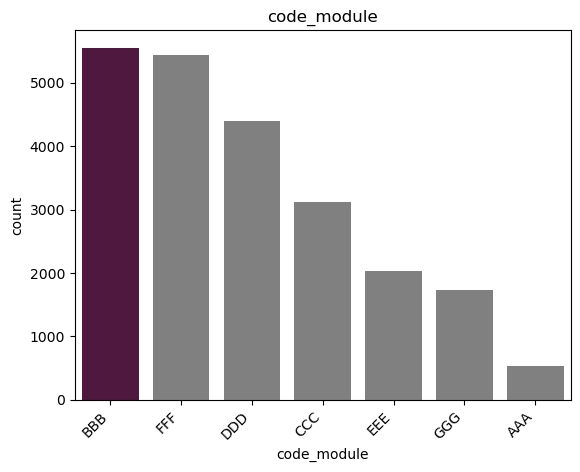

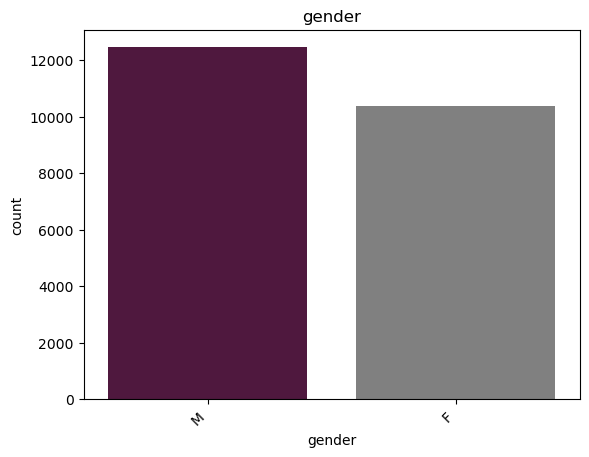

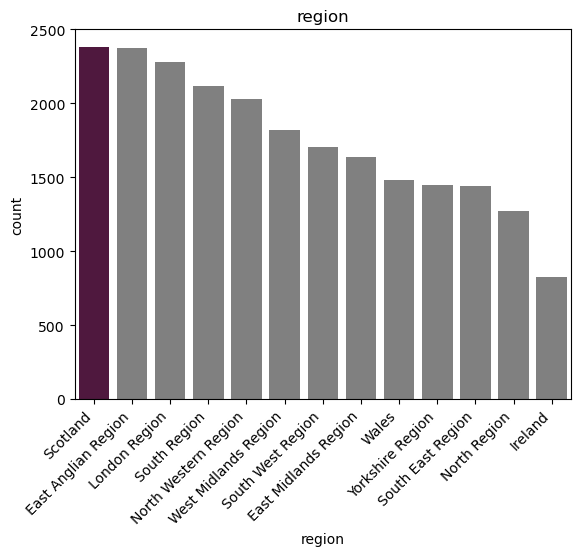

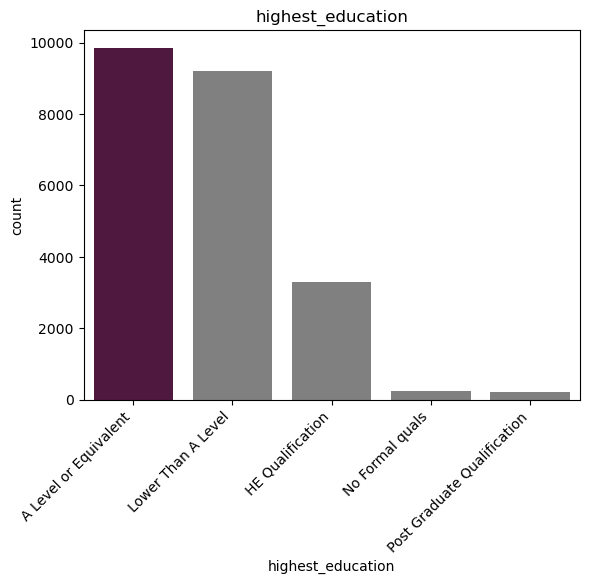

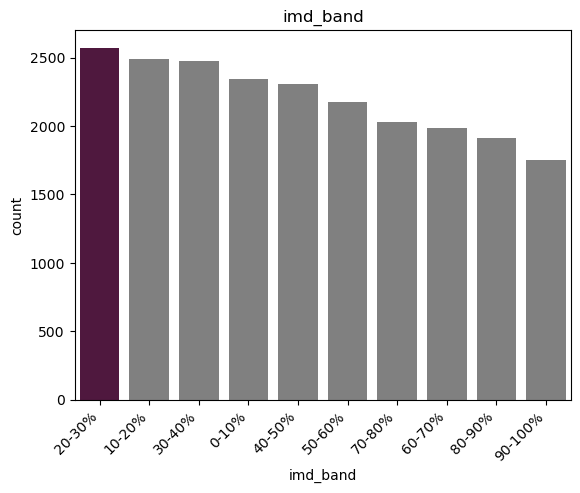

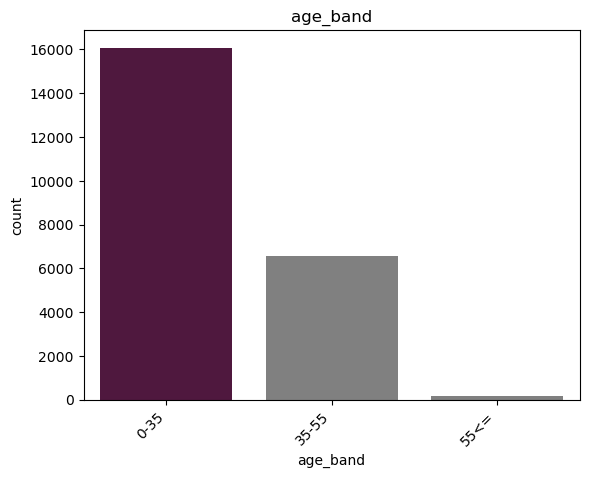

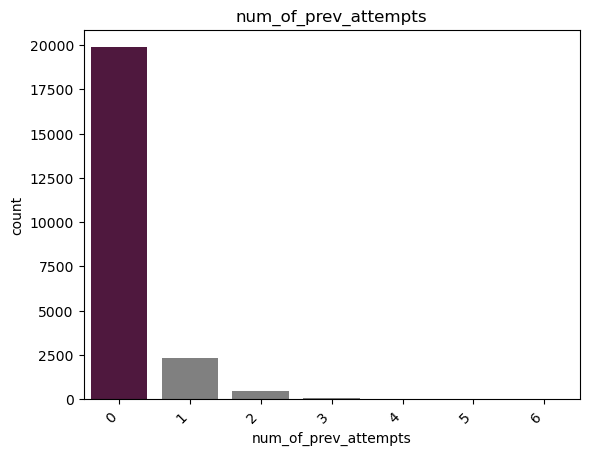

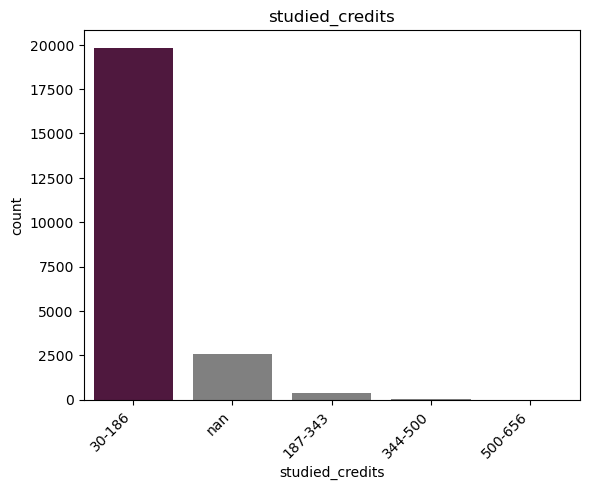

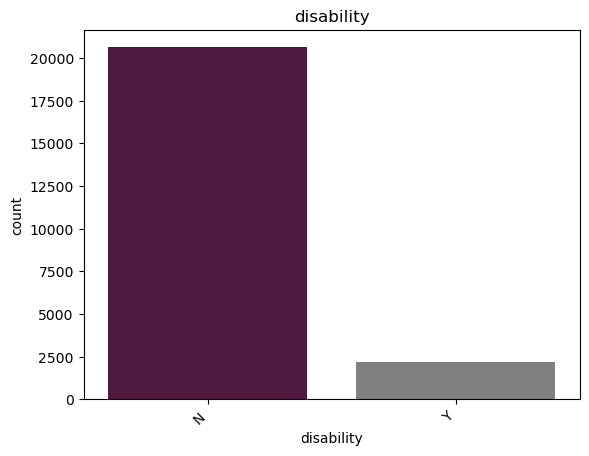

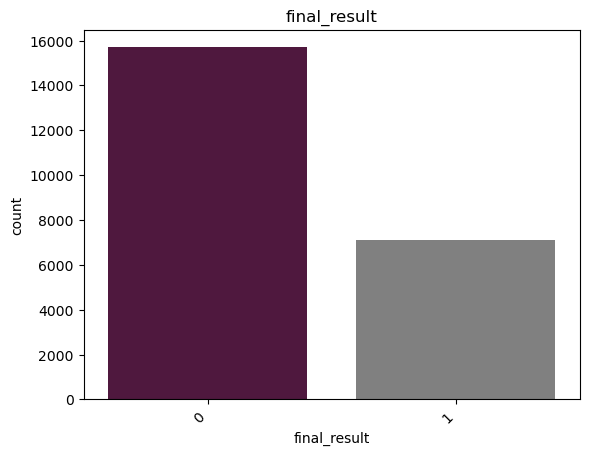

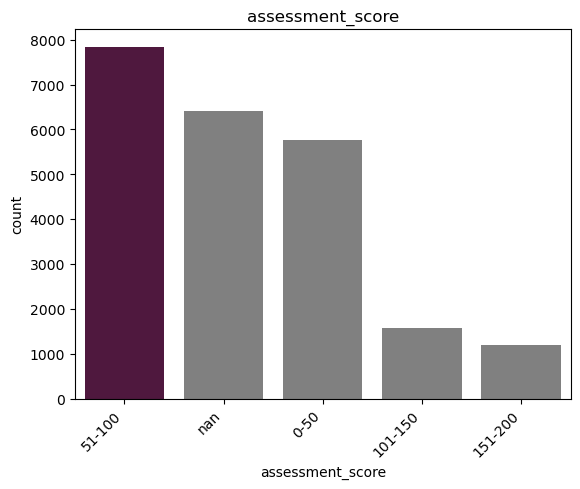

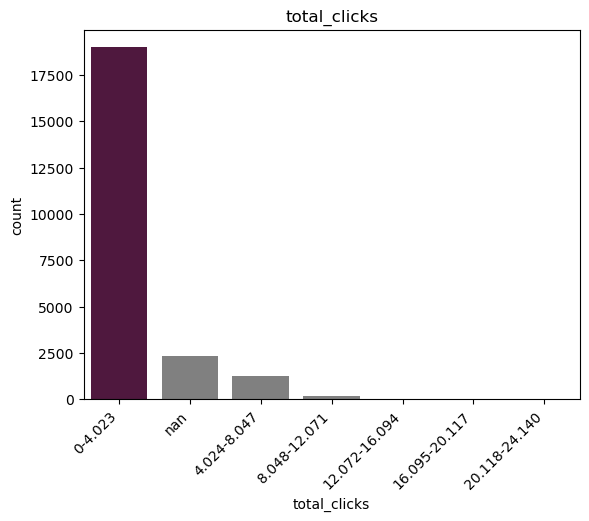

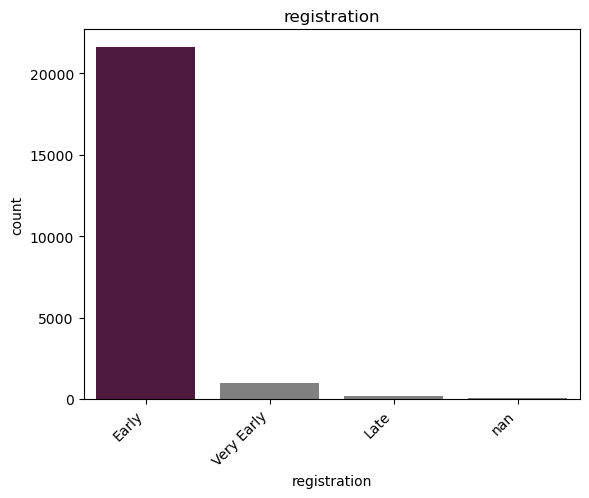

In [222]:
import seaborn as sns
for i in X_train.columns:
    cols = ['grey' if (x < max(X_train[i].value_counts())) else "#580F41" for x in X_train[i].value_counts()]
    sns.barplot(x=X_train[i].value_counts().index, y=X_train[i].value_counts(),palette=cols).set_title(i)
    plt.xticks(rotation=45, ha='right')
    #figure(figsize=(2, 1), dpi=80) 
    plt.show()

We can see that in the columns studied_credits, total_clicks and registration we have null values. We will deal with them later.

## Converting categorical columns to ordinal

Now it's time to replace all values with ordinal values.

In [223]:
combine = [X_train, X_test]

In [224]:
module_converting = {'AAA':1, 'BBB':2, 'CCC':3, 'DDD':4, 'EEE':5, 'FFF':6, 'GGG':7}
for dataset in combine:
    dataset['code_module'] = dataset['code_module'].map(module_converting)
    dataset['code_module'] = dataset['code_module'].fillna(2)

X_train.head()

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,assessment_score,total_clicks,registration
4166,2,F,North Region,A Level or Equivalent,70-80%,0-35,0,30-186,N,0,0-50,0-4.023,Early
26235,6,M,London Region,A Level or Equivalent,40-50%,35-55,0,30-186,N,1,nan,0-4.023,Early
12392,3,M,North Region,A Level or Equivalent,0-10%,0-35,0,30-186,N,1,nan,nan,Early
20245,5,F,South Region,A Level or Equivalent,70-80%,0-35,0,30-186,N,0,51-100,0-4.023,Early
20005,5,M,North Region,A Level or Equivalent,30-40%,0-35,0,30-186,N,0,0-50,0-4.023,Early


In [225]:
module_converting = {'F':0, 'M':1}
for dataset in combine:
    dataset['gender'] = dataset['gender'].map(module_converting)
    dataset['gender'] = dataset['gender'].fillna(1)

X_train.head()

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,assessment_score,total_clicks,registration
4166,2,0,North Region,A Level or Equivalent,70-80%,0-35,0,30-186,N,0,0-50,0-4.023,Early
26235,6,1,London Region,A Level or Equivalent,40-50%,35-55,0,30-186,N,1,nan,0-4.023,Early
12392,3,1,North Region,A Level or Equivalent,0-10%,0-35,0,30-186,N,1,nan,nan,Early
20245,5,0,South Region,A Level or Equivalent,70-80%,0-35,0,30-186,N,0,51-100,0-4.023,Early
20005,5,1,North Region,A Level or Equivalent,30-40%,0-35,0,30-186,N,0,0-50,0-4.023,Early


In [226]:
module_converting = {'HE Qualification':1, 'A Level or Equivalent':2, 'Lower Than A Level':3, 'Post Graduate Qualification':4, 'No Formal quals':5}
for dataset in combine:
    dataset['highest_education'] = dataset['highest_education'].map(module_converting)
    dataset['highest_education'] = dataset['highest_education'].fillna(2)

X_train.head()  
 

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,assessment_score,total_clicks,registration
4166,2,0,North Region,2,70-80%,0-35,0,30-186,N,0,0-50,0-4.023,Early
26235,6,1,London Region,2,40-50%,35-55,0,30-186,N,1,nan,0-4.023,Early
12392,3,1,North Region,2,0-10%,0-35,0,30-186,N,1,nan,nan,Early
20245,5,0,South Region,2,70-80%,0-35,0,30-186,N,0,51-100,0-4.023,Early
20005,5,1,North Region,2,30-40%,0-35,0,30-186,N,0,0-50,0-4.023,Early


In [227]:
module_converting = {'0-10%':0, '10-20%':1, '20-30%':2, '30-40%':3, '40-50%':4, '50-60%':5, '60-70%':6, '70-80%':7, '80-90%':8, '90-100%':9}
for dataset in combine:
    dataset['imd_band'] = dataset['imd_band'].map(module_converting)
    dataset['imd_band'] = dataset['imd_band'].fillna(2)

X_train.head()      
  

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,assessment_score,total_clicks,registration
4166,2,0,North Region,2,7.0,0-35,0,30-186,N,0,0-50,0-4.023,Early
26235,6,1,London Region,2,4.0,35-55,0,30-186,N,1,nan,0-4.023,Early
12392,3,1,North Region,2,0.0,0-35,0,30-186,N,1,nan,nan,Early
20245,5,0,South Region,2,7.0,0-35,0,30-186,N,0,51-100,0-4.023,Early
20005,5,1,North Region,2,3.0,0-35,0,30-186,N,0,0-50,0-4.023,Early


In [228]:
module_converting = {'0-35':1, '35-55':2, '55<=':3}
for dataset in combine:
    dataset['age_band'] = dataset['age_band'].map(module_converting)
    dataset['age_band'] = dataset['age_band'].fillna(1)

X_train.head()    

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,assessment_score,total_clicks,registration
4166,2,0,North Region,2,7.0,1,0,30-186,N,0,0-50,0-4.023,Early
26235,6,1,London Region,2,4.0,2,0,30-186,N,1,nan,0-4.023,Early
12392,3,1,North Region,2,0.0,1,0,30-186,N,1,nan,nan,Early
20245,5,0,South Region,2,7.0,1,0,30-186,N,0,51-100,0-4.023,Early
20005,5,1,North Region,2,3.0,1,0,30-186,N,0,0-50,0-4.023,Early


In [229]:
module_converting = {'Very Early':1, 'Early':2, 'Late':3}
for dataset in combine:
    dataset['registration'] = dataset['registration'].map(module_converting)
    dataset['registration'] = dataset['registration'].fillna(2)

X_train.head()    

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,assessment_score,total_clicks,registration
4166,2,0,North Region,2,7.0,1,0,30-186,N,0,0-50,0-4.023,2.0
26235,6,1,London Region,2,4.0,2,0,30-186,N,1,nan,0-4.023,2.0
12392,3,1,North Region,2,0.0,1,0,30-186,N,1,nan,nan,2.0
20245,5,0,South Region,2,7.0,1,0,30-186,N,0,51-100,0-4.023,2.0
20005,5,1,North Region,2,3.0,1,0,30-186,N,0,0-50,0-4.023,2.0


In [230]:
module_converting = {'N':0, 'Y':1}
for dataset in combine:
    dataset['disability'] = dataset['disability'].map(module_converting)
    dataset['disability'] = dataset['disability'].fillna(0)

X_train.head()

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,assessment_score,total_clicks,registration
4166,2,0,North Region,2,7.0,1,0,30-186,0,0,0-50,0-4.023,2.0
26235,6,1,London Region,2,4.0,2,0,30-186,0,1,nan,0-4.023,2.0
12392,3,1,North Region,2,0.0,1,0,30-186,0,1,nan,nan,2.0
20245,5,0,South Region,2,7.0,1,0,30-186,0,0,51-100,0-4.023,2.0
20005,5,1,North Region,2,3.0,1,0,30-186,0,0,0-50,0-4.023,2.0


We have many regions, so we are going to group them.. Regions that are close to each other are categorised together.

In [231]:
module_converting = {'Yorkshire Region':1, 'Scotland':1, 'North Western Region':1, 'North Region':1, 'Ireland':2, 'South Region':3,  'South West Region':3, 'South East Region':3, 'West Midlands Region':3, 'London Region':3, 'East Anglian Region':4, 'East Midlands Region':4, 'Wales':4}
for dataset in combine:
    dataset['region'] = dataset['region'].map(module_converting)
    dataset['region'] = dataset['region'].fillna(1)

X_train.head()     

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,assessment_score,total_clicks,registration
4166,2,0,1,2,7.0,1,0,30-186,0,0,0-50,0-4.023,2.0
26235,6,1,3,2,4.0,2,0,30-186,0,1,nan,0-4.023,2.0
12392,3,1,1,2,0.0,1,0,30-186,0,1,nan,nan,2.0
20245,5,0,3,2,7.0,1,0,30-186,0,0,51-100,0-4.023,2.0
20005,5,1,1,2,3.0,1,0,30-186,0,0,0-50,0-4.023,2.0


In [232]:
module_converting = {'0-4.023':1, '4.024-8.047':2, '8.048-12.071':3, '12.072-16.094':4, '16.095-20.117':5, '20.118-24.140':6}
for dataset in combine:
    dataset['total_clicks'] = dataset['total_clicks'].map(module_converting)
    dataset['total_clicks'] = dataset['total_clicks'].fillna(1)

X_train.head()   

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,assessment_score,total_clicks,registration
4166,2,0,1,2,7.0,1,0,30-186,0,0,0-50,1.0,2.0
26235,6,1,3,2,4.0,2,0,30-186,0,1,nan,1.0,2.0
12392,3,1,1,2,0.0,1,0,30-186,0,1,nan,1.0,2.0
20245,5,0,3,2,7.0,1,0,30-186,0,0,51-100,1.0,2.0
20005,5,1,1,2,3.0,1,0,30-186,0,0,0-50,1.0,2.0


In [233]:
module_converting = {'0-50':1, '51-100':2, '101-150':3, '151-200':4}
for dataset in combine:
    dataset['assessment_score'] = dataset['assessment_score'].map(module_converting)
    dataset['assessment_score'] = dataset['assessment_score'].fillna(1)

X_train.head() 

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,assessment_score,total_clicks,registration
4166,2,0,1,2,7.0,1,0,30-186,0,0,1.0,1.0,2.0
26235,6,1,3,2,4.0,2,0,30-186,0,1,1.0,1.0,2.0
12392,3,1,1,2,0.0,1,0,30-186,0,1,1.0,1.0,2.0
20245,5,0,3,2,7.0,1,0,30-186,0,0,2.0,1.0,2.0
20005,5,1,1,2,3.0,1,0,30-186,0,0,1.0,1.0,2.0


In [234]:
module_converting = {'30-186':1, '187-343':2, '344-500':3, '500-656':4}
for dataset in combine:
    dataset['studied_credits'] = dataset['studied_credits'].map(module_converting)
    dataset['studied_credits'] = dataset['studied_credits'].fillna(1)
X_train.head()   

,code_module,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,assessment_score,total_clicks,registration
4166,2,0,1,2,7.0,1,0,1.0,0,0,1.0,1.0,2.0
26235,6,1,3,2,4.0,2,0,1.0,0,1,1.0,1.0,2.0
12392,3,1,1,2,0.0,1,0,1.0,0,1,1.0,1.0,2.0
20245,5,0,3,2,7.0,1,0,1.0,0,0,2.0,1.0,2.0
20005,5,1,1,2,3.0,1,0,1.0,0,0,1.0,1.0,2.0


# USING DIFFERENT METHODS FOR PREDICTION

In [235]:
X_train_r = X_train.drop("final_result", axis=1)
Y_train_r = X_train["final_result"]
X_test_r = X_test.drop("final_result", axis=1).copy()
X_train_r.shape, Y_train_r.shape, X_test_r.shape

((22815, 12), (22815,), (9778, 12))

## LOGISTIC REGRESSION MODEL

Logistic regression is a useful model to run early in the workflow.

The confidence score is 81.2 and is generated by the model based on our training dataset.

In [236]:
logreg = LogisticRegression()
logreg.fit(X_train_r, Y_train_r)
Y_pred = logreg.predict(X_test_r)
acc_log = round(logreg.score(X_train_r, Y_train_r) * 100, 2)
acc_log

81.2

**COEFFICIENT**

We can observe from the coefficients below that:

Disability has the highest positive correlation, that means that when teyh student has a disability,  increases the probability to drop out from the course. 
Assessment score has the highest negative correlation, which means that when Assessment score increases then probability to drop out of the course decreases.

In [237]:
coeff_df = pd.DataFrame(X_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
7,disability,1.060863
1,region,0.553063
8,final_result,0.215759
4,age_band,0.012297
2,highest_education,0.005694
5,num_of_prev_attempts,-0.055670
3,imd_band,-0.055795
6,studied_credits,-0.207298
0,gender,-0.283101
10,total_clicks,-0.724801
